<a href="https://colab.research.google.com/github/vladimbo/Bayesian/blob/master/PyMC3_dice_polls.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
pip install git+https://github.com/arviz-devs/arviz

  Cloning https://github.com/arviz-devs/arviz to /tmp/pip-req-build-v58juy7d
  Running command git clone -q https://github.com/arviz-devs/arviz /tmp/pip-req-build-v58juy7d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for arviz: filename=arviz-0.6.1-cp36-none-any.whl size=2598802 sha256=1f3e4de3b36ee91b81fcf15797556bec124e2a006af7174f0b8fc937e94e703c
  Stored in directory: /tmp/pip-ephem-wheel-cache-dkwq34ur/wheels/93/b7/76/fe5931eb8154ca105ee91ddc249c6e1eaaa7b06988bdf8a400
Successfully built arviz


https://towardsdatascience.com/calogica-com-dice-polls-dirichlet-multinomials-eca987e6ec3f


In [0]:
import numpy as np
from scipy import stats
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as arviz
import pymc3 as pm

In [40]:
y = np.asarray([20,  21, 17, 19, 17, 28])
k = len(y)
p = 1/k
n = y.sum()
print(n, p)

122 0.16666666666666666


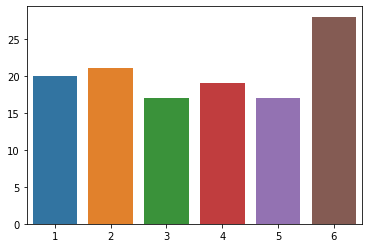

In [33]:
sns.barplot(x=np.arange(1, k+1), y=y);

In [0]:
with pm.Model() as dice_model:
    
    # initializes the Dirichlet distribution with a uniform prior:
    a = np.ones(k) 
    
    theta = pm.Dirichlet("theta", a=a)
    
    # Since theta[5] will hold the posterior probability 
    # of rolling a 6 we'll compare this to the 
    # reference value p = 1/6 to determine the amount of bias
    # in the die 
    six_bias = pm.Deterministic("six_bias", theta[k-1] - p)
    
    results = pm.Multinomial("results", n=n, p=theta, observed=y)

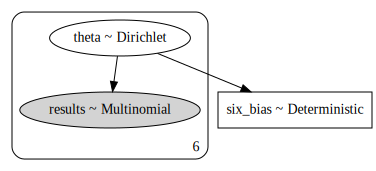

In [25]:
pm.model_to_graphviz(dice_model)

In [42]:
with dice_model:
    dice_trace = pm.sample(draws=1000) 

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]
100%|██████████| 1500/1500 [00:01<00:00, 798.42it/s]


polling analysis into elections - candidate A, candidate B, other

In [0]:
y = np.asarray([727, 583, 137])
n = y.sum()
k = len(y)

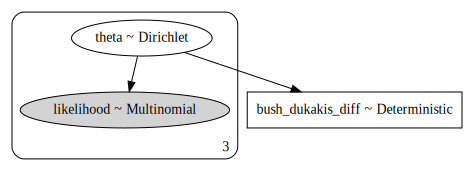

In [50]:
with pm.Model() as polling_model:
    
    # initializes the Dirichlet distribution with a uniform prior:
    a = np.ones(k) 
    
    theta = pm.Dirichlet("theta", a=a)
    
    bush_dukakis_diff = pm.Deterministic("bush_dukakis_diff",
                                          theta[0] - theta[1])
    
    likelihood = pm.Multinomial("likelihood", 
                                 n=n, 
                                 p=theta, 
                                 observed=y)
pm.model_to_graphviz(polling_model)

In [51]:
with polling_model:
    polling_trace = pm.sample(draws=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]
100%|██████████| 1500/1500 [00:01<00:00, 1083.05it/s]


/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


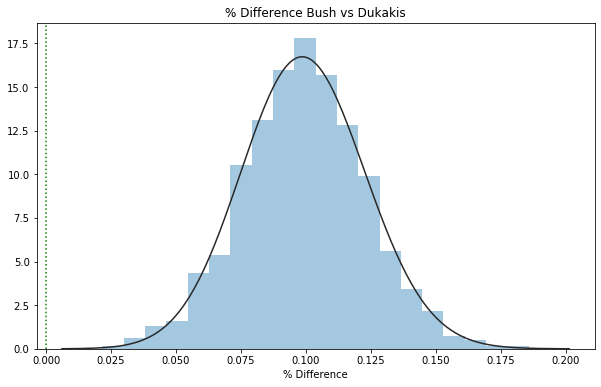

In [52]:
_, ax = plt.subplots(1,1, figsize=(10, 6))
sns.distplot(polling_trace["bush_dukakis_diff"], 
     bins=20, ax=ax, kde=False, fit=stats.beta)
ax.axvline(0, c='g', linestyle='dotted')
ax.set_title("% Difference Bush vs Dukakis")
ax.set_xlabel("% Difference");

In [53]:
diff = polling_trace["bush_dukakis_diff"]
bush_dukakis_diff_perc = len(diff[diff>0])/len(diff)
      
print(f'P(More Responses for Bush) = {bush_dukakis_diff_perc:.0%}')


P(More Responses for Bush) = 100%


pre and post debate or two polls in time 

In [73]:
data = pd.DataFrame([
        {"candidate": "bush", "pre": 294, "post": 278},
        {"candidate": "dukakis", "pre": 307, "post": 322},
        {"candidate": "other", "pre": 38, "post": 10}
       ], columns=["candidate", "pre", "post"])

print(data.head())

  candidate  pre  post
0      bush  294   278
1   dukakis  307   322
2     other   38    10


In [74]:
y = data[["pre", "post"]].T.values
print(y) 

[[294 307  38]
 [278 322  10]]


In [75]:
# Number of respondents in each survey:
n = y.sum(axis=1) 
print(n)

[639 610]


In [77]:
# Number of respondents for the 2 major candidates in each survey:
m = y[:, :2].sum(axis=1) 
print(m) 

[601 600]


In [78]:
n_debates, n_candidates = y.shape
print(n_debates, n_candidates) 

2 3


In [79]:
with pm.Model() as polling_model_debates:
    
    # initializes the Dirichlet distribution with a uniform prior:
    shape = (n_debates, n_candidates)
    a = np.ones(shape)
    
    # This creates a separate Dirichlet distribution for each debate
    # where sum of probabilities across candidates = 100% 
    # for each debate
    theta = pm.Dirichlet("theta", a=a, shape=shape)
    
    # get the "Bush" theta for each debate, at index=0
    # and normalize across supporters for the 2 major candidates
    bush_pref = pm.Deterministic("bush_pref", theta[:, 0] * n / m)
    
    # to calculate probability that support for Bush 
    # shifted from debate 1 [0] to 2 [1]
    bush_shift = pm.Deterministic("bush_shift", 
        bush_pref[1]-bush_pref[0])
    
    # because of the shapes of the inputs, 
    # this essentially creates 2 multinomials, 
    # one for each debate
    responses = pm.Multinomial("responses", 
        n=n, p=theta, observed=y)

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [80]:
for v in polling_model_debates.unobserved_RVs:
    print(v, v.tag.test_value.shape)

theta_stickbreaking__ (2, 2)
theta (2, 3)
bush_pref (2,)
bush_shift ()


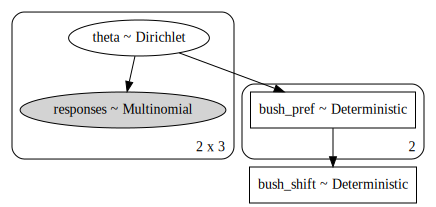

In [81]:
pm.model_to_graphviz(polling_model_debates)

In [82]:
with polling_model_debates:
    polling_trace_debates = pm.sample(draws=3000, tune=1500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [theta]
100%|██████████| 4500/4500 [00:05<00:00, 809.62it/s]


In [85]:
import arviz as arviz
with polling_model_debates:
    pm.traceplot(polling_trace_debates, combined=True)

ImportError: ignored

In [86]:
s = ["pre", "post"]
candidates = data["candidate"].values
pd.DataFrame(polling_trace_debates["theta"].mean(axis=0), 
    index=s, 
    columns=candidates)

,bush,dukakis,other
pre,0.459349,0.479898,0.060753
post,0.455219,0.526775,0.018006


In [87]:
pd.DataFrame(polling_trace_debates["bush_pref"].mean(axis=0),  
    index=s, columns=["bush_pref"])

,bush_pref
pre,0.488393
post,0.462806


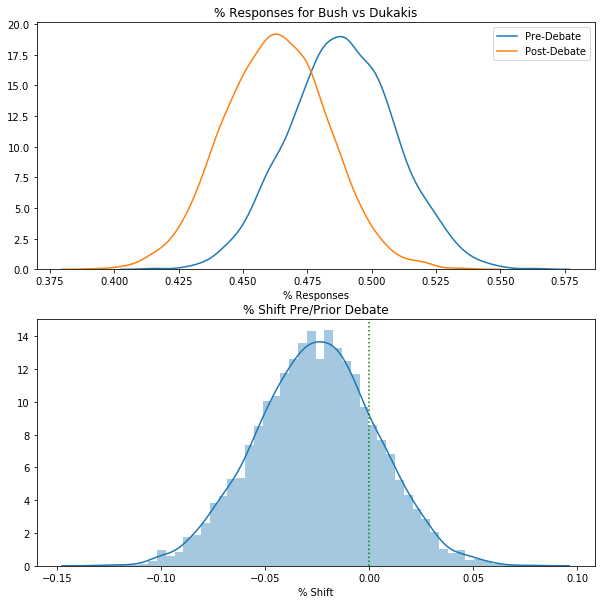

In [88]:
_, ax = plt.subplots(2,1, figsize=(10, 10))
sns.distplot(polling_trace_debates["bush_pref"][:,0], 
    hist=False, ax=ax[0], label="Pre-Debate")
sns.distplot(polling_trace_debates["bush_pref"][:,1], 
    hist=False, ax=ax[0], label="Post-Debate")
ax[0].set_title("% Responses for Bush vs Dukakis")
ax[0].set_xlabel("% Responses");
sns.distplot(polling_trace_debates["bush_shift"], 
    hist=True, ax=ax[1], label="P(Bush Shift)")
ax[1].axvline(0, c='g', linestyle='dotted')
ax[1].set_title("% Shift Pre/Prior Debate")
ax[1].set_xlabel("% Shift");

In [89]:
bush_shift = polling_trace_debates["bush_shift"]
perc_shift = (
              len(bush_shift[bush_shift > 0])
              /len(bush_shift)
             )
print(f'P(Shift Towards Bush) = {perc_shift:.1%}')


P(Shift Towards Bush) = 18.8%
